<a href="https://colab.research.google.com/github/chimaobi-okite/NLP-Books-Implementation/blob/main/FinetuneBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT** 

Bidirectional Encoder Representations from Transformers attends to tokens at the same time. There are two types available 

* The bert-base 
* The bert-large.

The differentiating factor between the two above is the size. Bert uses learned positional encodings unlike the original transformer and was pretrained on Masked language modelling and Next sentence prediction tasks. 

Here we would finetune a bert model for Acceptability Judgements downstream task and measure the predictions with the Matthews Correlation
Coefficient (MCC). 

#### Installing the Hugging Face PyTorch interface for BERT And Importing Modules

In [1]:
# installing hugging face pytorch interface for bert
!pip install -q transformers 

In [2]:
## importing modules
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange #progress bar module

## standard python modules
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from torch.cuda import is_available
# using cuda as device for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

#### Loading the dataset

The dataset used is the CoLA based on the Warstadt et al. (2018) paper. It tells how acceptable an english sentence is.

In [4]:
# loading the dataset from books github repo
# source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter02/in_domain_train.tsv", delimiter='\t', header=None,
names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [5]:
# randomly select 10 examples from the train data
df.sample(10)

# data definition
# Column 1: the source of the sentence (code)
# Column 2: the label (0=unacceptable, 1=acceptable)
# Column 3: the label annotated by the author
# Column 4: the sentence to be classified

,sentence_source,label,label_notes,sentence
8073,ad03,1,NaN,jason was killed .
7999,ad03,1,NaN,the poem that homer wrote .
7405,sks13,1,NaN,she is the mother of john .
6885,m_02,1,NaN,near strasbourg my brother lives .
7670,sks13,0,*,it convinced bill that mary should sleep .
7223,sks13,1,NaN,the spy became too friendly with his new conta...
3690,ks08,1,NaN,he has a rail pass that 's right for you .
206,cj99,0,*,"the more articles he reads , the fewer people ..."
1565,r-67,1,NaN,i gave the book to harvey because he asked me ...
3055,l-93,1,NaN,susan whispered for me to come .


#### Creating sentences, label list and adding Bert tokens

In [6]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values
# Adding CLS and SEP tokens at the beginning and end of each sentence for Bert
sentences = ['CLS ' + sentence + ' SEP' for sentence in sentences]
labels = df.label.values

#### Activating Bert Tokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['cl', '##s', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', 'sep']


#### Process Data

In [8]:
# since the length of data in our training set is small 47, lets set max_len to 128
# original paper uses 512
MAX_LEN = 128
# convert tokens to index numbers in Bert Tokenizer
input_ids = [tokenizer.convert_tokens_to_ids(token) for token in tokenized_texts]
# pad sequences 
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype='long', padding = 'post', truncating= 'post')

#### Creating Attention Masks
attention mask tells the model the aspect of the input_ids to ignore is the padded tokens

In [9]:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

#### Split Data Into Training and Validation Sets


In [10]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
input_ids,random_state=42, test_size=0.1)

#### Converting Data To Tensors

In [11]:
## inputs to our model require tensors as gpu works specifically with tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

#### Selecting a batch size and creating an iterator

In [12]:
## the bert authors recommend a batch size of 16 or 32 for fine tuning
## iterator aviods loading the entire dataset into memory which might lead to crash
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler = train_sampler , batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#### BERT model configuration

In [13]:
#@title BERT Model Configuration
# Initializing a BERT bert-base-uncased style configuration
#@title Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  
from transformers import BertModel, BertConfig
configuration = BertConfig()
# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



#### Loading the Hugging Face BERT uncased base model

In [14]:
#@title Loading Hugging Face Bert uncased base model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Optimizer grouped parameters

In [15]:
##@title Optimizer Grouped Parameters
param_optimizer = list(model.named_parameters()) # list of all named parameters
no_decay = ['bias', 'LayerNorm.weight']  # do not add weigth decay on bias and layerNorm.weigth parameters
optimizer_grouped_parameters = [
{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.1},
{'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}
]


#### HyperParameters for training loop

In [16]:
epochs = 4 # Number of training epochs (authors recommend between 2 and 4)

optimizer = AdamW(optimizer_grouped_parameters,lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * epochs ## number of train step

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## function to evaluate model
def flat_accuracy(preds, labels):
  preds_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(preds_flat == labels_flat)/len(labels_flat)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


#### Model Training

In [17]:
t = []
train_loss_set = []        # store loss and accuracy for plotting

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  model.train()       # set model to training
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  for step, batch in enumerate(train_loader):
    batch = tuple(t.to(device) for t in batch) # add batch to gpu
    b_input_ids, b_input_mask, b_labels = batch # unpack inputs from dataloader
    optimizer.zero_grad()    # avoid acumulating grads
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)   # Forward pass
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    loss.backward() # Backward pass
    optimizer.step()   # Update parameters and take a step using the computed gradient
    scheduler.step()    # Update the learning rate.
    
    
    tr_loss += loss.item()  # Update tracking variables
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation
  model.eval()      # Put model in evaluation mode to evaluate loss on the validation set
  eval_loss, eval_accuracy = 0, 0   # Tracking variables 
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():   # don not compute loss
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = logits['logits'].detach().cpu().numpy()   # Move logits and labels to CPU
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.553974292213986


Epoch:  25%|██▌       | 1/4 [02:47<08:21, 167.02s/it]

Validation Accuracy: 0.7916666666666666
Train loss: 0.3951948141965134


Epoch:  50%|█████     | 2/4 [05:33<05:33, 166.96s/it]

Validation Accuracy: 0.8140432098765432
Train loss: 0.26286546397505955


Epoch:  75%|███████▌  | 3/4 [08:20<02:46, 166.75s/it]

Validation Accuracy: 0.8117283950617284
Train loss: 0.18851678449799658


Epoch: 100%|██████████| 4/4 [11:06<00:00, 166.71s/it]

Validation Accuracy: 0.8070987654320988


#### Training evaluation

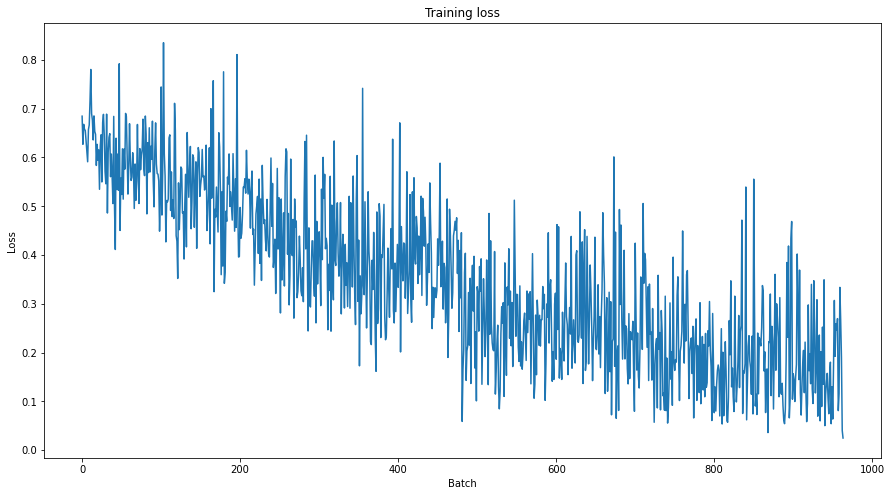

In [18]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

#### Predicting and Valuating using Holdout Validation Data

In [19]:
## get the test sef also stored in the books github repo
df = pd.read_csv('https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter02/out_of_domain_dev.tsv',
                 delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# process the test data same way we did for training data
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32    

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [20]:
# Prediction on test set
model.eval()
predictions , true_labels = [], []  # Tracking variables 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

#### Evaluating using Matthews Correlation Coefficient

GLUE - General Language Understanding Evaluation evaluate linguistic acceptability with MCC which canbe easily imported from sklearn. Lets see what this entails

In [21]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [22]:
# see score on individual batches
matthews_set

[-0.14856415213808927,
 0.0,
 0.25471776097404686,
 0.2757127976394358,
 0.24816038707378335,
 0.5807564950208268,
 0.29277002188455997,
 -0.06788442333021306,
 0.7453559924999299,
 0.5114083119567587,
 0.4127594582445936,
 0.4472135954999579,
 0.45693676673168776,
 0.5447047794019222,
 0.060522753266880246,
 0.32660542964119055,
 0.0]

In [23]:
## evaluate mcc on the whole test data
flat_predictions = [item for sublist in predictions for item in
sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in
sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.348210384394441

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(flat_predictions,flat_true_labels)

0.7461240310077519

### Summary

I was able to learn how to finetune a bert model and also alot on how it works. The MCC wasnt so great but in a positive direction, alot can still be improved